<div style="text-align:center">
    <h1>
        Advantage Actor-Critic (A2C)
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to combine temporal difference learning (TD) with policy gradient methods. The resulting algorithm is called Advantage Actor-Critic (A2C) and uses a one-step estimate of the return to update the policy:
</div>

\begin{equation}
\hat G_t = R_{t+1} + \gamma v(S_{t+1}|w)
\end{equation}


<br>

## Packages Installation

In [ ]:
'''Command to install all the dependencies listed in the file.'''
# %pip install -r requirements.txt

## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

In [2]:
from typing import Tuple, Dict, Optional, Iterable, Callable

import seaborn as sns
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw

## Setup Code: Environment

In [3]:
class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances

## Setup Code: Utilities

In [4]:
def create_animation(image_list, interval=200):
    """
    Create and display an animation from a list of RGB images in a Jupyter Notebook.
    
    Parameters:
        image_list (list of numpy arrays): List of RGB images.
        interval (int): Interval between frames in milliseconds.
    
    Returns:
        anim (HTML object): The animation as an HTML object to be displayed in the notebook.
    """
    fig, ax = plt.subplots()
    
    def update(frame):
        ax.clear()
        ax.imshow(image_list[frame])
        ax.axis('off')
    
    anim = animation.FuncAnimation(fig, update, frames=len(image_list), interval=interval)
    plt.close(fig)  # Close the figure to prevent it from displaying statically
    
    return HTML(anim.to_jshtml())

def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return create_animation(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

<>:73: SyntaxWarning: invalid escape sequence '\p'
<>:73: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Md. Siam\AppData\Local\Temp\ipykernel_38312\3293031306.py:73: SyntaxWarning: invalid escape sequence '\p'
  plt.title("$\pi(s)$", size=16)


## Create and preprocess the environment

### Create the environment

In [5]:
env = gym.make('Acrobot-v1')

In [6]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 6. Actions: 3
Sample state: [ 0.99687177 -0.07903557  0.99531657  0.09666901  0.02658918 -0.00621153]


In [ ]:
'''
The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain 
above a given height while starting from the initial state of hanging downwards.
'''

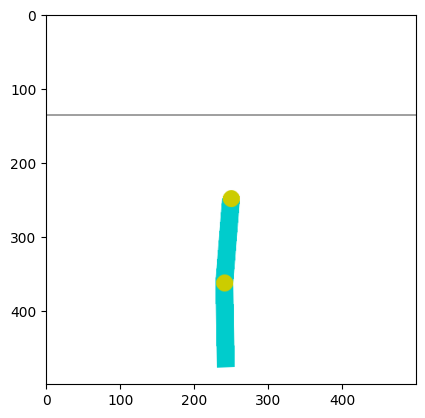

In [7]:
plt.imshow(env.render(mode='rgb_array'))

### Prepare the environment to work with PyTorch

In [8]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()

    def step(self, actions):
        actions = actions.squeeze().numpy()
        next_state, reward, done, info = self.env.step(actions)
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [9]:
num_envs = 8
parallel_env = gym.vector.make('Acrobot-v1', num_envs=num_envs)
seed_everything(parallel_env)
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

In [10]:
actor = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1))

### Create the value network $v(s)$

In [11]:
critic = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

## Implement the algorithm


In [12]:
def actor_critic(actor, critic, episodes, alpha=1e-4, gamma=0.99):
    actor_optim = AdamW(actor.parameters(), lr=1e-3)
    critic_optim = AdamW(critic.parameters(), lr=1e-4)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        I = 1.

        while not done_b.all():
            action = actor(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)

            value = critic(state)
            target = reward + ~done * gamma * critic(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            critic.zero_grad()
            critic_loss.backward()
            critic_optim.step()

            advantage = (target - value).detach()
            probs = actor(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action)
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            actor.zero_grad()
            actor_loss.backward()
            actor_optim.step()

            ep_return += reward
            done_b |= done
            state = next_state
            I = I * gamma

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats

In [13]:
stats = actor_critic(actor, critic, 100)

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


## Show results

### Show execution stats

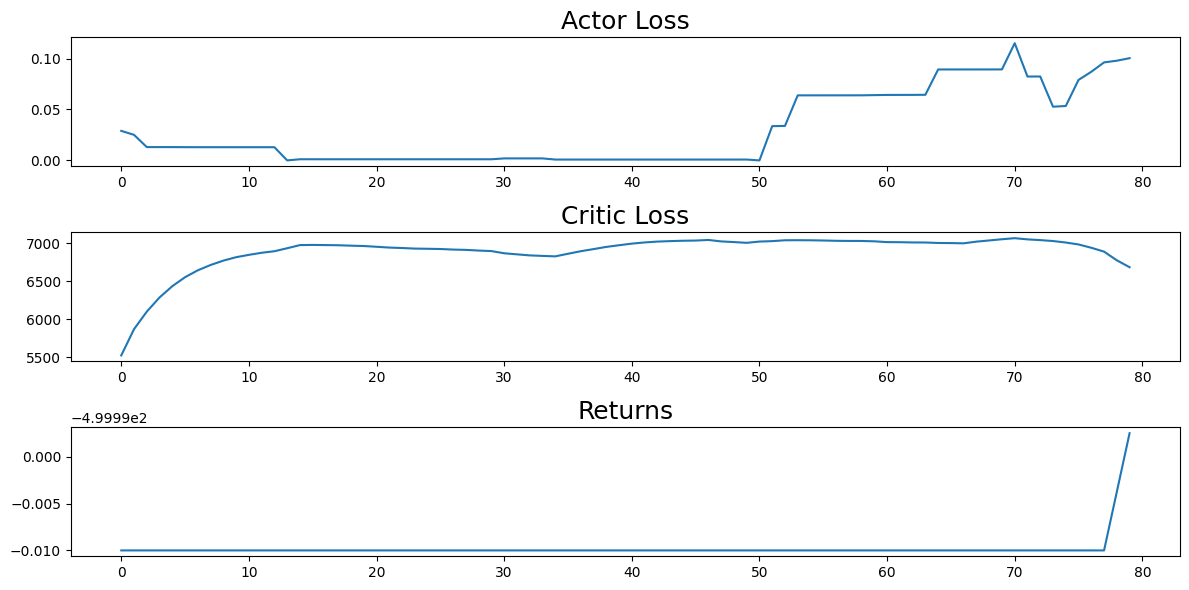

In [14]:
plot_stats(stats)

### Test the resulting agent

In [15]:
test_policy_network(env, actor, episodes=2)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)